In [1]:
shared_cts = ['L6_IT_CTX_Glut',
 'CA1-ProS_Glut',
 'STR-PAL_Chst9_Gaba',
 'Pvalb_Gaba',
 'L23_IT_ENT_Glut',
 'OPC_NN',
 'L23_IT_CTX_Glut',
 'L5_ET_CTX_Glut',
 'L23_IT_PPP_Glut',
 'Lamp5_Gaba',
 'CA3_Glut',
 'Sst_Gaba',
 'LA-BLA-BMA-PA_Glut',
 'SUB-ProS_Glut',
 'Microglia_NN',
 'Astro-NT_NN',
 'Oligo_NN',
 'L6_CT_CTX_Glut',
 'L5_NP_CTX_Glut',
 'Vip_Gaba',
 'STR_D1_Sema5a_Gaba',
 'Astro-TE_NN',
 'DG_Glut',
 'VLMC_NN',
 'L6bCT_ENT_Glut',
 ] #'STR_D1_Gaba'

In [2]:
import glob
import pandas as pd
import subprocess
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy import barplot, dotplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [3]:
fc_cutoff = 0.1
pvalue_cutoff = 1e-5

In [4]:
all_deg_paths = glob.glob('New.Domain.Genes.Expression/*/DiffExpress.DomainGene.csv')

In [5]:
def get_luisa_deg(ct):
    deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
    expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
    use_genes = expr[expr.sum(axis = 1) > 0.1].index
    stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)
    
    luisa_deg = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
    luisa_deg['log2(18mo/2mo)'] = np.log2(luisa_deg['fc']) 
    luisa_deg['-log10(padj)'] = -np.log10(luisa_deg['fdr'] + _min)
    luisa_deg =luisa_deg[luisa_deg['fdr'] < 0.5]
    return luisa_deg

In [6]:
all_diff_domain = pd.read_csv('ALL.Diff.Domain.csv', index_col = 0)
all_diff_domain = all_diff_domain[all_diff_domain['celltype'].isin(shared_cts)]

In [7]:
example_cts = all_diff_domain['celltype'].value_counts().index[:6]
example_cts = ['DG_Glut', 'CA1-ProS_Glut', 'L23_IT_CTX_Glut','L6_CT_CTX_Glut']

In [8]:
luisa_dir = '/data/female-amb/Diff.Result/luisa_deg'
gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]

In [9]:
ct_degs = {}
for ct in example_cts:
    all_deg = pd.read_csv(f"{luisa_dir}/{ct}.csv", index_col = 0)
    all_deg['-log10(padj)'] = -np.log10(all_deg['p_val_adj']+ 1e-300)
    all_deg['log2(18mo/2mo)'] = -all_deg['avg_log2FC']
    all_deg = all_deg[(abs(all_deg['log2(18mo/2mo)']) > fc_cutoff) & (all_deg['p_val_adj'] <  pvalue_cutoff)]
    
    all_overlap = pd.read_csv(f'New.Domain.Genes.Expression/{ct}/All.Overlap.Domain.Genes.csv', index_col ='gene_name')
    all_overlap= all_overlap[all_overlap['18mo-8wk'] > 0]
    shared_deg_df = all_deg[all_deg.index.isin(all_overlap.index)]
    ct_degs[ct] = list(shared_deg_df.index)

In [10]:
all_df = []
for ct, gene_list in ct_degs.items():
    go_enrichment = gp.enrichr(gene_list= gene_list,
                           gene_sets=['GO_Biological_Process_2023'],#'GO_Molecular_Function_2018','KEGG_2016','WikiPathways_2019_Mouse','KEGG_2019_Mouse'
                           organism='Mouse', # don't forget to set organism
                           #outdir='test/go', # set the output directory
                           no_plot=False, # do not draw a plot
                           cutoff=0.05) # set a significance cutoff
    #filter for GO result
    result_df= go_enrichment.results.copy()
    
    result_df = result_df[result_df['P-value']  < 1e-3]
    result_df['num_genes'] = result_df['Overlap'].apply(lambda x: int(x.split('/')[0]))
    result_df = result_df[result_df['num_genes'] >= 3]
    
    result_df['-log10(p)'] = -np.log10(result_df['P-value'] + 1e-50)
    result_df =result_df.set_index('Term')[['-log10(p)']]
    result_df.index = [_go.split('(')[0] for _go in result_df.index]
    result_df.columns = [ct]
    all_df.append(result_df)
    
all_df = pd.concat(all_df, axis = 1)
#all_df = all_df[all_df.isna().sum(axis = 1) < (all_df.shape[1] -2)].fillna(0)
# drop columns that are all na
#select the first 4 columns


In [11]:
for ct, gene_list in ct_degs.items():
    go_enrichment = gp.enrichr(gene_list= gene_list,
                           gene_sets=['GO_Biological_Process_2023'],#'GO_Molecular_Function_2018','KEGG_2016','WikiPathways_2019_Mouse','KEGG_2019_Mouse'
                           organism='Mouse', # don't forget to set organism
                           #outdir='test/go', # set the output directory
                           no_plot=False, # do not draw a plot
                           cutoff=0.05) # set a significance cutoff
    #filter for GO result
    result_df= go_enrichment.results.copy()
    break

In [129]:
all_df = all_df.fillna(0)
all_df.head()

,DG_Glut,CA1-ProS_Glut,L23_IT_CTX_Glut,L6_CT_CTX_Glut
Regulation Of Amyloid-Beta Formation,4.149916,0.0,0.0,0.0
Protein Kinase C-activating G Protein-Coupled Receptor Signaling Pathway,3.720304,0.0,0.0,0.0
Chondroitin Sulfate Proteoglycan Biosynthetic Process,3.568201,0.0,0.0,0.0
Regulation Of Amyloid Precursor Protein Catabolic Process,3.535182,0.0,0.0,0.0
Glycosaminoglycan Biosynthetic Process,3.294889,0.0,0.0,0.0


In [130]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

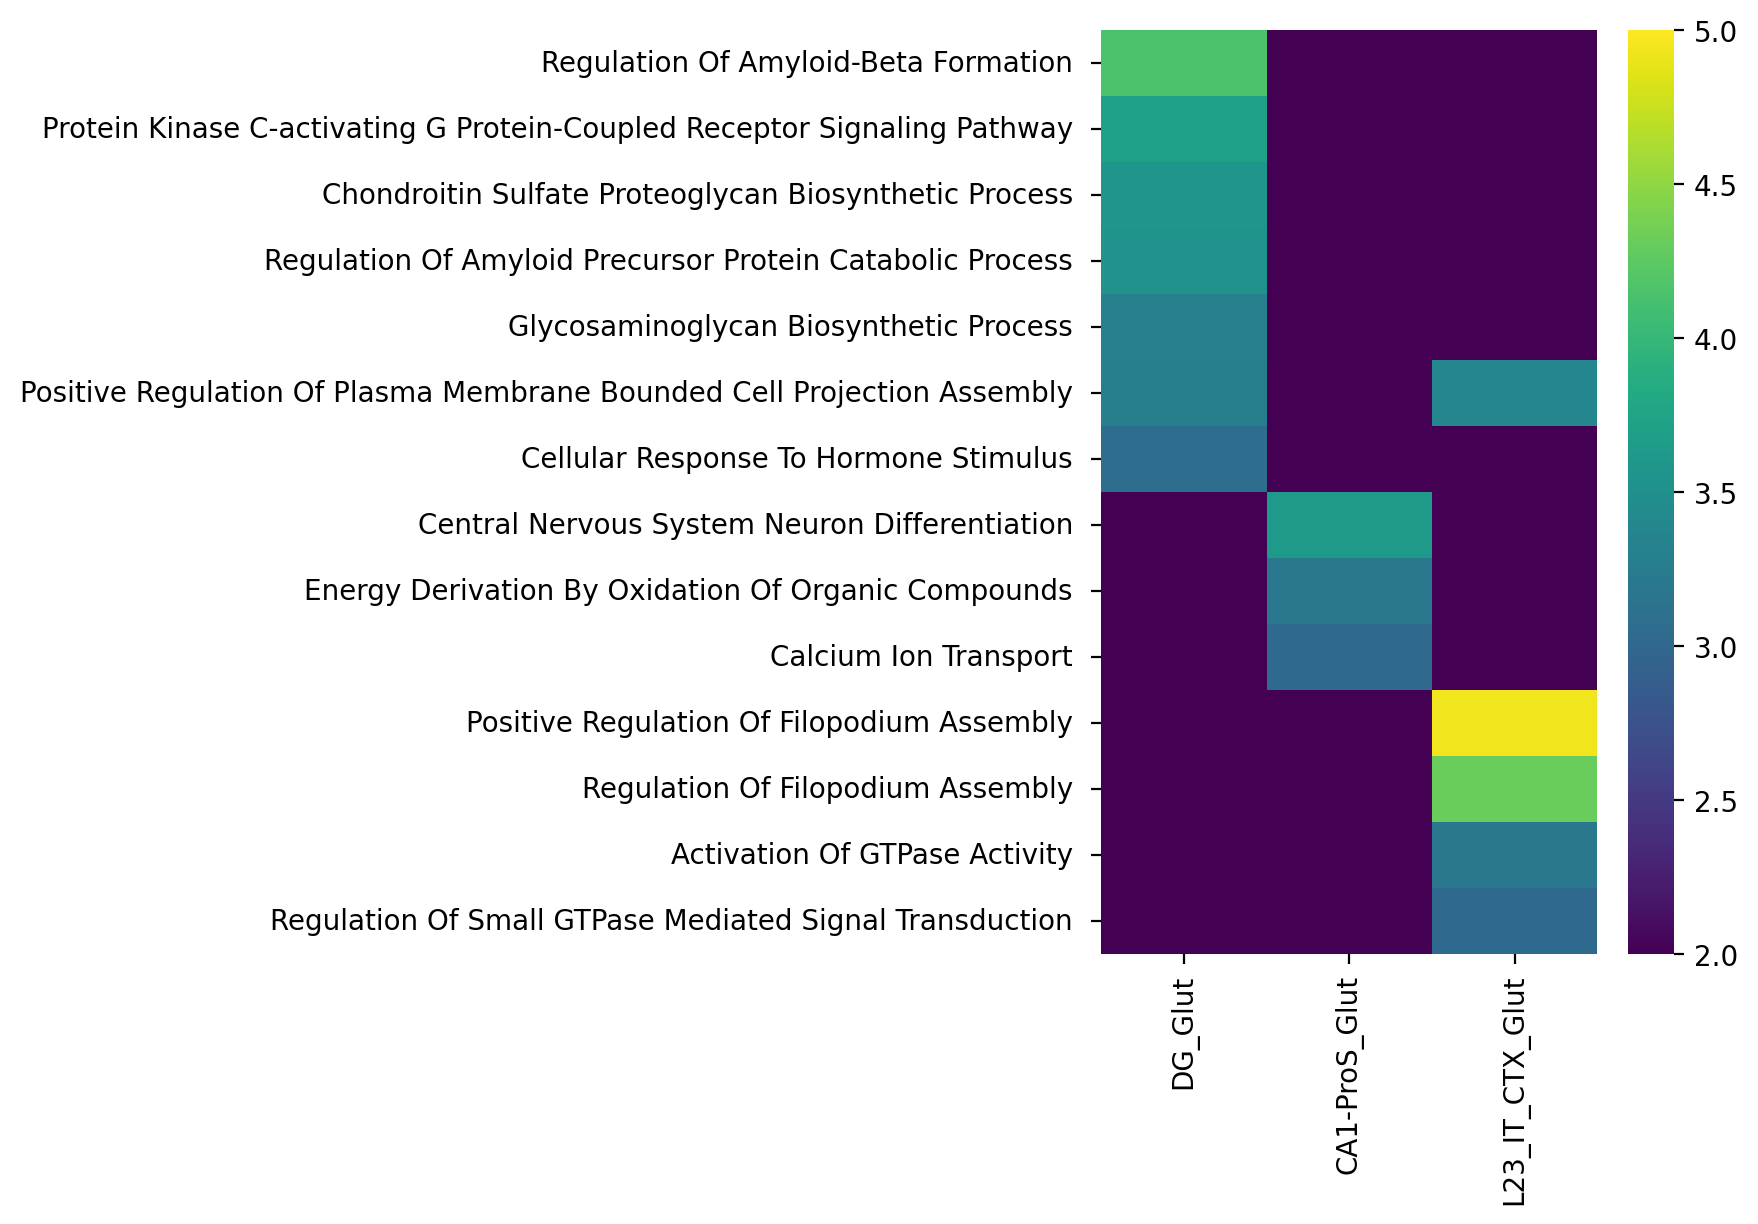

In [133]:
fig, ax = plt.subplots(figsize=(4, 6), dpi = 200)
sns.heatmap(all_df.iloc[:,0:3], 
            ax = ax,
            cmap = 'viridis',
            vmin = 2,
            vmax = 5,
            yticklabels=True)
fig.savefig(f'figure/GO_domain_genes.pdf', bbox_inches='tight')

In [27]:
all_genes = []
for ct, gene_list in ct_degs.items():
    all_genes += gene_list
all_genes = list(set(all_genes))

In [28]:
go_enrichment = gp.enrichr(gene_list= all_genes,
                           gene_sets=['GO_Biological_Process_2023'],#'GO_Molecular_Function_2018','KEGG_2016','WikiPathways_2019_Mouse','KEGG_2019_Mouse'
                           organism='Mouse', # don't forget to set organism
                           #outdir='test/go', # set the output directory
                           no_plot=False, # do not draw a plot
                           cutoff=0.05) # set a significance cutoff


In [29]:
#filter for GO result
result_df= go_enrichment.results.copy()
result_df = result_df[result_df['Adjusted P-value']  < 0.01]
result_df['num_genes'] = result_df['Overlap'].apply(lambda x: int(x.split('/')[0]))
result_df = result_df[result_df['num_genes'] >= 3]
result_df = result_df[['P-value','Term']]
result_df.head()

,P-value,Term
0,4.160266e-07,Cytoplasmic Translation (GO:0002181)


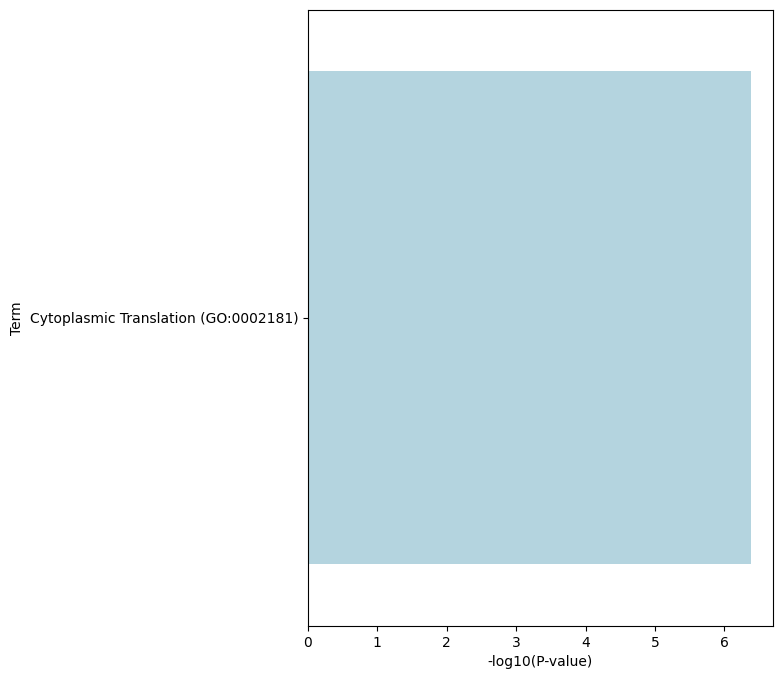

In [30]:
result_df['-log10(P-value)'] = -np.log10(result_df['P-value'])
plt.figure(figsize=(6, 8))
bar_plot = sns.barplot(x='-log10(P-value)',
                       color = 'lightblue',
                       y='Term', 
                       data=result_df, 
                       )

In [13]:
#gene_sets = gp.get_library_name(organism='Mouse')

In [14]:
#all_df[all_df['degs'].isin(['Rps15a','Rps5','Rps27a','Rps23','Rpl28','Rpl27a'])]